## **8th Annual WiDS Datathon Challenges:** 

### **Unraveling the Mysteries of the Female Brain**

# BEST MODELS

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    multilabel_confusion_matrix
)

from imblearn.over_sampling import SMOTE

from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [6]:
X_train = pd.read_csv("../data/processed/model/X_train.csv")
X_test = pd.read_csv("../data/processed/model/X_test.csv")
X_val = pd.read_csv("../data/processed/test_fcm_pca.csv")

y_train = pd.read_csv("../data/processed/model/y_train.csv")
y_test = pd.read_csv("../data/processed/model/y_test.csv")

participant_id = X_val['participant_id']
X_val = X_val.drop(columns=['participant_id'])

y_train_adhd = to_categorical(y_train['ADHD_Outcome'], num_classes=2)
y_train_sex = to_categorical(y_train['Sex_F'], num_classes=2)

y_test_adhd = to_categorical(y_test['ADHD_Outcome'], num_classes=2)
y_test_sex = to_categorical(y_test['Sex_F'], num_classes=2)

In [7]:
# Convert labels to numerical format for SMOTE
y_train_adhd_labels = np.argmax(y_train_adhd, axis=1)
y_train_sex_labels = np.argmax(y_train_sex, axis=1)

# Identify indices for females with ADHD (Sex_F = 1 and ADHD_Outcome = 1)
female_adhd_indices = np.where((y_train_sex_labels == 1) & (y_train_adhd_labels == 1))[0]
X_train_female_adhd = X_train.iloc[female_adhd_indices]
y_train_adhd_female_adhd = y_train_adhd_labels[female_adhd_indices]

# Apply SMOTE if there is more than one UNIQUE class to oversample FROM
if len(np.unique(y_train_adhd_female_adhd)) > 1:
    smote = SMOTE(random_state=42)
    X_train_female_adhd_resampled, y_train_adhd_female_adhd_resampled = smote.fit_resample(X_train_female_adhd, y_train_adhd_female_adhd)

    # Identify indices for the rest of the training data
    remaining_indices = np.where(~((y_train_sex_labels == 1) & (y_train_adhd_labels == 1)))[0]
    X_train_remaining = X_train.iloc[remaining_indices]
    y_train_adhd_remaining = y_train_adhd[remaining_indices]
    y_train_sex_remaining = y_train_sex[remaining_indices]

    # Combine the resampled female ADHD data with the rest
    X_train_resampled = pd.concat([X_train_female_adhd_resampled, X_train_remaining], axis=0)
    y_train_adhd_resampled_labels = np.concatenate([y_train_adhd_female_adhd_resampled, np.argmax(y_train_adhd_remaining, axis=1)], axis=0)
    y_train_sex_resampled = pd.concat([y_train_sex[female_adhd_indices].iloc[[0]*len(y_train_adhd_female_adhd_resampled)], y_train_sex_remaining], axis=0)

    # Convert the resampled ADHD labels back to categorical
    y_train_adhd_resampled = to_categorical(y_train_adhd_resampled_labels, num_classes=2)
else:
    print("Warning: No or only one class found for females with ADHD. Skipping SMOTE for this group.")
    X_train_resampled = X_train.copy()
    y_train_adhd_resampled = y_train_adhd.copy()
    y_train_sex_resampled = y_train_sex.copy()

input_layer = Input(shape=(X_train_resampled.shape[1],))

x = Dense(256, activation='elu', kernel_regularizer=l2(0.0001))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='elu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='elu')(x)
x = BatchNormalization()(x)

adhd_output = Dense(2, activation='softmax', name='adhd_output')(x)
sex_output = Dense(2, activation='softmax', name='sex_output')(x)

model = Model(inputs=input_layer, outputs=[adhd_output, sex_output])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'adhd_output': 'categorical_crossentropy', 'sex_output': 'categorical_crossentropy'},
    metrics={'adhd_output': ['accuracy'], 'sex_output': ['accuracy']}
)

checkpoint = ModelCheckpoint(
    'best_model_smote_female_adhd.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1),
    checkpoint
]

history = model.fit(
    X_train_resampled,
    {'adhd_output': y_train_adhd_resampled, 'sex_output': y_train_sex_resampled},
    validation_data=(X_test, {'adhd_output': y_test_adhd, 'sex_output': y_test_sex}),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

results = model.evaluate(X_test, {'adhd_output': y_test_adhd, 'sex_output': y_test_sex}, verbose=0)
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

y_pred_p = model.predict(X_test)
y_pred_a = np.argmax(y_pred_p[0], axis=1)
y_pred_s = np.argmax(y_pred_p[1], axis=1)

print("\nClassification Report for ADHD_Outcome (after SMOTE on female ADHD):")
print(classification_report(y_test['ADHD_Outcome'], y_pred_a))

print("\nClassification Report for Sex_F (after SMOTE on female ADHD):")
print(classification_report(y_test['Sex_F'], y_pred_s))

print("\nConfusion Matrix for ADHD_Outcome (after SMOTE on female ADHD):")
print(confusion_matrix(y_test['ADHD_Outcome'], y_pred_a))

print("\nConfusion Matrix for Sex_F (after SMOTE on female ADHD):")
print(confusion_matrix(y_test['Sex_F'], y_pred_s))

y_pred_probs = model.predict(X_val)
y_pred_adhd = np.argmax(y_pred_probs[0], axis=1)
y_pred_sex = np.argmax(y_pred_probs[1], axis=1)

submission = pd.DataFrame({
    'participant_id': participant_id,
    'ADHD_Outcome': y_pred_adhd,
    'Sex_F': y_pred_sex
})

submission.to_csv('submission_nn1.csv', index=False)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - adhd_output_accuracy: 0.4827 - adhd_output_loss: 0.9821 - loss: 1.9440 - sex_output_accuracy: 0.5526 - sex_output_loss: 0.9052
Epoch 1: val_loss improved from inf to 1.45989, saving model to best_model_smote_female_adhd.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - adhd_output_accuracy: 0.4834 - adhd_output_loss: 0.9806 - loss: 1.9418 - sex_output_accuracy: 0.5530 - sex_output_loss: 0.9044 - val_adhd_output_accuracy: 0.6193 - val_adhd_output_loss: 0.6781 - val_loss: 1.4599 - val_sex_output_accuracy: 0.5596 - val_sex_output_loss: 0.7284 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - adhd_output_accuracy: 0.7917 - adhd_output_loss: 0.4728 - loss: 0.9480 - sex_output_accuracy: 0.8161 - sex_output_loss: 0.4174
Epoch 2: val_loss did not improve from 1.45989
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - adhd_output_accuracy: 0.7911 - adhd_output_loss: 0.4733 - loss: 0.9481 - sex_output_accuracy: 0.8162 - sex_output_loss: 0.4171 - val_adhd_output_accuracy: 0.6606 - val_adhd_output_loss: 0.7154 - val_loss: 1.4623 - val_sex_output_accuracy: 0.6651 - val_sex_output_loss: 0.6908 - learning_rate: 0.0010
Epoch 3/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - adhd_output_accuracy: 0.8421 - adh

In [8]:
# Convert labels to numerical format for SMOTE
y_train_adhd_labels = np.argmax(y_train_adhd, axis=1)
y_train_sex_labels = np.argmax(y_train_sex, axis=1)

# Identify indices for females with ADHD (Sex_F = 1 and ADHD_Outcome = 1)
female_adhd_indices = np.where((y_train_sex_labels == 1) & (y_train_adhd_labels == 1))[0]
X_train_female_adhd = X_train.iloc[female_adhd_indices]
y_train_adhd_female_adhd = y_train_adhd_labels[female_adhd_indices]

# Apply SMOTE if there is more than one UNIQUE class to oversample FROM
if len(np.unique(y_train_adhd_female_adhd)) > 1:
    smote = SMOTE(random_state=42)
    X_train_female_adhd_resampled, y_train_adhd_female_adhd_resampled = smote.fit_resample(X_train_female_adhd, y_train_adhd_female_adhd)

    # Identify indices for the rest of the training data
    remaining_indices = np.where(~((y_train_sex_labels == 1) & (y_train_adhd_labels == 1)))[0]
    X_train_remaining = X_train.iloc[remaining_indices]
    y_train_adhd_remaining = y_train_adhd[remaining_indices]
    y_train_sex_remaining = y_train_sex[remaining_indices]

    # Combine the resampled female ADHD data with the rest
    X_train_resampled = pd.concat([X_train_female_adhd_resampled, X_train_remaining], axis=0)
    y_train_adhd_resampled_labels = np.concatenate([y_train_adhd_female_adhd_resampled, np.argmax(y_train_adhd_remaining, axis=1)], axis=0)
    y_train_sex_resampled = pd.concat([y_train_sex[female_adhd_indices].iloc[[0]*len(y_train_adhd_female_adhd_resampled)], y_train_sex_remaining], axis=0)

    # Convert the resampled ADHD labels back to categorical
    y_train_adhd_resampled = to_categorical(y_train_adhd_resampled_labels, num_classes=2)
else:
    print("Warning: No or only one class found for females with ADHD. Skipping SMOTE for this group.")
    X_train_resampled = X_train.copy()
    y_train_adhd_resampled = y_train_adhd.copy()
    y_train_sex_resampled = y_train_sex.copy()

input_layer = Input(shape=(X_train_resampled.shape[1],))

x = Dense(256, activation='elu', kernel_regularizer=l2(0.0001))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='elu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='elu')(x)
x = BatchNormalization()(x)

adhd_output = Dense(2, activation='softmax', name='adhd_output')(x)
sex_output = Dense(2, activation='softmax', name='sex_output')(x)

model = Model(inputs=input_layer, outputs=[adhd_output, sex_output])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'adhd_output': 'categorical_crossentropy', 'sex_output': 'categorical_crossentropy'},
    metrics={'adhd_output': ['accuracy'], 'sex_output': ['accuracy']}
)

checkpoint = ModelCheckpoint(
    'best_model_smote_female_adhd.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1),
    checkpoint
]

history = model.fit(
    X_train_resampled,
    {'adhd_output': y_train_adhd_resampled, 'sex_output': y_train_sex_resampled},
    validation_data=(X_test, {'adhd_output': y_test_adhd, 'sex_output': y_test_sex}),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

results = model.evaluate(X_test, {'adhd_output': y_test_adhd, 'sex_output': y_test_sex}, verbose=0)
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

y_pred_p = model.predict(X_test)
y_pred_a = np.argmax(y_pred_p[0], axis=1)
y_pred_s = np.argmax(y_pred_p[1], axis=1)

print("\nClassification Report for ADHD_Outcome (after SMOTE on female ADHD):")
print(classification_report(y_test['ADHD_Outcome'], y_pred_a))

print("\nClassification Report for Sex_F (after SMOTE on female ADHD):")
print(classification_report(y_test['Sex_F'], y_pred_s))

print("\nConfusion Matrix for ADHD_Outcome (after SMOTE on female ADHD):")
print(confusion_matrix(y_test['ADHD_Outcome'], y_pred_a))

print("\nConfusion Matrix for Sex_F (after SMOTE on female ADHD):")
print(confusion_matrix(y_test['Sex_F'], y_pred_s))

y_pred_probs = model.predict(X_val)
y_pred_adhd = np.argmax(y_pred_probs[0], axis=1)
y_pred_sex = np.argmax(y_pred_probs[1], axis=1)

submission = pd.DataFrame({
    'participant_id': participant_id,
    'ADHD_Outcome': y_pred_adhd,
    'Sex_F': y_pred_sex
})

submission.to_csv('submission_nn2.csv', index=False)


Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - adhd_output_accuracy: 0.5266 - adhd_output_loss: 0.9713 - loss: 1.9840 - sex_output_accuracy: 0.5041 - sex_output_loss: 0.9560
Epoch 1: val_loss improved from inf to 1.41807, saving model to best_model_smote_female_adhd.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - adhd_output_accuracy: 0.5272 - adhd_output_loss: 0.9696 - loss: 1.9800 - sex_output_accuracy: 0.5049 - sex_output_loss: 0.9537 - val_adhd_output_accuracy: 0.6376 - val_adhd_output_loss: 0.7046 - val_loss: 1.4181 - val_sex_output_accuracy: 0.6468 - val_sex_output_loss: 0.6563 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - adhd_output_accuracy: 0.7692 - adhd_output_loss: 0.4945 - loss: 0.9875 - sex_output_accuracy: 0.8104 - sex_output_loss: 0.4353
Epoch 2: val_loss did not improve from 1.41807
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - adhd_output_accuracy: 0.7694 - adhd_output_loss: 0.4944 - loss: 0.9873 - sex_output_accuracy: 0.8103 - sex_output_loss: 0.4354 - val_adhd_output_accuracy: 0.6055 - val_adhd_output_loss: 0.7488 - val_loss: 1.4538 - val_sex_output_accuracy: 0.6651 - val_sex_output_loss: 0.6439 - learning_rate: 0.0010
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - adhd_output_accuracy: 0.8362 - adh

Classification Report (Test Set):


--- ADHD_Outcome ---
              precision    recall  f1-score   support

           0       0.35      0.32      0.34        68
           1       0.70      0.73      0.71       150

    accuracy                           0.60       218
   macro avg       0.53      0.53      0.53       218
weighted avg       0.59      0.60      0.60       218

Weighted F1 Score for ADHD_Outcome: 0.6323

--- Sex_F ---
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       143
           1       0.57      0.57      0.57        75

    accuracy                           0.70       218
   macro avg       0.67      0.67      0.67       218
weighted avg       0.70      0.70      0.70       218

Weighted F1 Score for Sex_F: 0.7023

Average Weighted F1 Score (Final Score): 0.6673

Multi-label Confusion Matrix:
[[[ 22  46]
  [ 41 109]]

 [[110  33]
  [ 32  43]]]


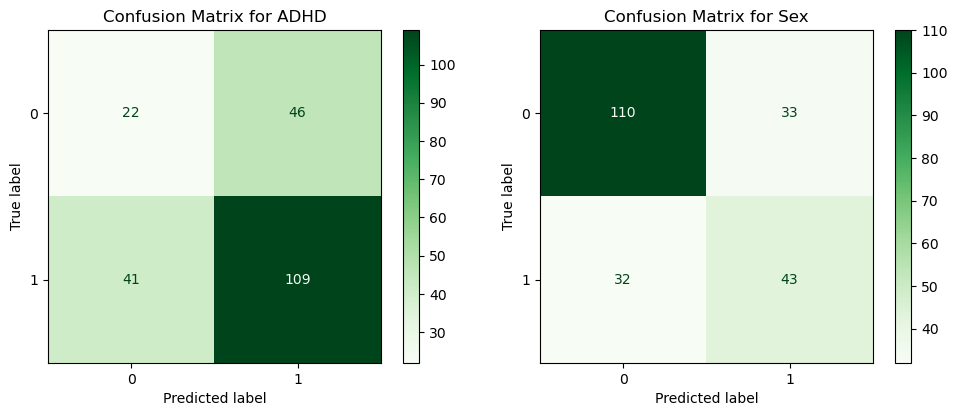

Submission_LR file saved as submission.csv


In [9]:
base_model = LogisticRegression(class_weight="balanced", solver='saga', penalty='l2', C=0.01, max_iter=500, random_state=42)
model = MultiOutputClassifier(base_model)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

def classification_report_adhd_sex(y_true, y_pred):
    print("Classification Report (Test Set):\n")
    
    f1_scores = []
    labels = ['ADHD_Outcome', 'Sex_F']
    
    y_true_np = y_true.to_numpy()
    
    for i, label in enumerate(labels):
        print(f"\n--- {label} ---")
        print(classification_report(y_true_np[:, i], y_pred[:, i], zero_division=0))
        
        if label == 'ADHD_Outcome':
            weight = np.where((y_true['ADHD_Outcome'] == 1) & (y_true['Sex_F'] == 1), 2, 1)
            f1 = f1_score(y_true_np[:, i], y_pred[:, i], sample_weight=weight, average='weighted')
        else:
            f1 = f1_score(y_true_np[:, i], y_pred[:, i], average='weighted')
        
        f1_scores.append(f1)
        print(f"Weighted F1 Score for {label}: {f1:.4f}")
    
    avg_f1 = np.mean(f1_scores)
    print(f"\nAverage Weighted F1 Score (Final Score): {avg_f1:.4f}")

    print("\nMulti-label Confusion Matrix:")
    print(multilabel_confusion_matrix(y_true, y_pred))

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, cm, title in zip(
        axes,
        [confusion_matrix(y_true['ADHD_Outcome'], y_pred[:, 0]),
         confusion_matrix(y_true['Sex_F'], y_pred[:, 1])],
        ['Confusion Matrix for ADHD', 'Confusion Matrix for Sex']
    ):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Greens', ax=ax, values_format='d')
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Run evaluation
classification_report_adhd_sex(y_test, y_pred_test)

# Predict on validation set
y_pred_val = model.predict(X_val)

# Format submission
submission = pd.DataFrame({
    "participant_id": participant_id,
    "ADHD_Outcome": y_pred_val[:, 0],
    "Sex_F": y_pred_val[:, 1]
})

submission.to_csv("submission_LR.csv", index=False)
print("Submission_LR file saved as submission.csv")